In [ ]:
!pip install demoji
!pip install WordCloud
!pip install pyLDAvis

# Basic
import numpy as np
import pandas as pd

# Data Cleaning
import re
import string
import demoji
demoji.download_codes()

# Data Pre-processing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from pprint import pprint
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

... OK (Got response in 0.26 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Buidling the LDA model
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.gensim
import pyLDAvis.sklearn
from sklearn.model_selection import *
from sklearn.decomposition import LatentDirichletAllocation
import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

# Sentiment Analysis
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Master - Classes/CIS 9665 - NLP/NLP Group Project/DATASET/20201117_230813_covid_tweets_50000.csv')
df.head(5)

,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags
0,KavitaNair,🇺🇸 🌟 Personal Account 🌟 Instagram @thekavitana...,NaN,291,733,7374,2008-09-18 01:08:47,2020-11-17 18:07:31,137,NEW: I just signed an Executive Order to lower...,"[{'text': 'COVID19', 'indices': [131, 139]}]"
1,annaholligan,Foreign correspondent @bbcnews Journalist. Fil...,"The Hague, The Netherlands",8168,23749,18951,2009-01-17 06:58:29,2020-11-17 18:07:31,0,"Dutch bars, cafes and restaurants will remain ...","[{'text': 'COVID19', 'indices': [259, 267]}]"
2,Champlow,Ubisoft⭐️_PLAYER 2019 x Trials Elite x Admin a...,Mordor,284,376,5078,2013-12-05 14:03:36,2020-11-17 18:07:31,0,Happy birthday 🙃\n#Covid_19 https://t.co/vIzzA...,"[{'text': 'Covid_19', 'indices': [17, 26]}]"
3,stshank,"Senior editor, CNET News. I cover browsers, ph...","SF Bay Area, CA",3633,30489,57043,2007-06-05 14:47:23,2020-11-17 18:07:31,0,The area of arctic sea ice that didn't melt be...,[]
4,JoelJeffcoat,NaN,NaN,293,113,19637,2017-04-18 18:30:24,2020-11-17 18:07:31,30,This is where we are. CEOs of the American Hos...,[]


In [ ]:
df2=pd.DataFrame(df["text"].unique()).reset_index().drop('index',axis=1)

df2.columns=['text']

# Data Cleaning 

In [ ]:
# Remove URL

def remove_URL(text):
    url = re.compile(r'http\S+')
    return url.sub(r'',text)

df2['text'] = df['text'].apply(lambda x : remove_URL(x))

In [ ]:
# Remove html tags

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

df2['text']=df2['text'].apply(lambda x : remove_html(x))

In [ ]:
# Remove emojis

def remove_emojis(text):
  new_text = demoji.replace(text, "")
  return new_text

df2['text'] = df2['text'].apply(lambda x: remove_emojis(x))

In [ ]:
# Remove mentions and hashtag

def remove_mention_hashtag(text):
    text=re.sub(r'@\w+','',text)        # remove mentions
    text=re.sub(r'#\w+','',text)        # remove hashtag
    return text

df2['text']=df2['text'].apply(lambda x: remove_mention_hashtag(x))

In [ ]:
# Remove Emails

def remove_emails(text):
  email = re.compile(r'\S*@\S*\s?')
  return email.sub(r'', text)

df2['text']=df2['text'].apply(lambda x : remove_emails(x))

In [ ]:
# Remove new line characters

def remove_newline(text):
  newline = re.compile(r'\n+')
  return newline.sub(r'', text)

df2['text']=df2['text'].apply(lambda x : remove_newline(x))

In [ ]:
# Remove extra white space left while removing stuff

def remove_space(text):
    whitespace_remove = re.compile(r'\s+')
    return whitespace_remove.sub(r' ', text)

df2["text"]=df2["text"].apply(lambda x: remove_space(x))

# Data Preprocessing

### Tweets Preprocessing 

In [ ]:
punct=string.punctuation+'”‘’“'

def clean_text(text):
#Make text lowercase
    text = text.lower()
#remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
#remove punctuation   
    text = re.sub(r'[%s]' % re.escape(punct), '', text)    
#remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    return text

tweets_df_clean = pd.DataFrame(df2["text"].apply(lambda x: clean_text(x)))

In [ ]:
# remove stopwords
stopwords = nltk.corpus.stopwords.words("english")
custom_stopwords = ['hi', '&amp;', 'amp', 'amp;', 'got', "it's", 'it’s', "i'm", 'im', 'want', 'like', '$', '@','covid','coronavirus','covid19','covid-19','u']
for i in custom_stopwords:
    stopwords.append(i)

def remove_stopwords(text):
    return " ".join(word for word in str(text).split() if word not in stopwords)
    
tweets_df_clean['text']=tweets_df_clean['text'].apply(lambda x: remove_stopwords(x))

In [ ]:
# Tokenization
tweets_df_clean["text"] = tweets_df_clean["text"].apply(word_tokenize)

In [ ]:
# Lemmatization 
def lemmatizing(text):
    lemmatizer =WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

tweets_df_clean["text"] = tweets_df_clean["text"].apply(lambda x: lemmatizing(x))

### Hashtags preprocessing 

In [ ]:
tweets_df_clean['hashtags_cleaned'] = df["hashtags"]

In [ ]:
tweets_df_clean['hashtags_cleaned'] = tweets_df_clean['hashtags_cleaned'].apply(lambda x : remove_URL(x))
tweets_df_clean['hashtags_cleaned'] = tweets_df_clean['hashtags_cleaned'].apply(lambda x : remove_html(x))
tweets_df_clean['hashtags_cleaned'] = tweets_df_clean['hashtags_cleaned'].apply(lambda x : remove_emojis(x))
tweets_df_clean['hashtags_cleaned'] = tweets_df_clean['hashtags_cleaned'].apply(lambda x : remove_mention_hashtag(x))
tweets_df_clean['hashtags_cleaned'] = tweets_df_clean['hashtags_cleaned'].apply(lambda x : remove_emails(x))
tweets_df_clean['hashtags_cleaned'] = tweets_df_clean['hashtags_cleaned'].apply(lambda x : remove_newline(x))
tweets_df_clean['hashtags_cleaned'] = tweets_df_clean['hashtags_cleaned'].apply(lambda x: remove_space(x))
tweets_df_clean['hashtags_cleaned'] = tweets_df_clean['hashtags_cleaned'].apply(lambda x: clean_text(x))
tweets_df_clean['hashtags_cleaned'] = tweets_df_clean['hashtags_cleaned'].apply(lambda x: remove_stopwords(x))
tweets_df_clean['hashtags_cleaned'] = tweets_df_clean['hashtags_cleaned'].apply(word_tokenize)
tweets_df_clean['hashtags_cleaned'] = tweets_df_clean['hashtags_cleaned'].apply(lambda x: lemmatizing(x))

In [ ]:
extra = ["text", "index"]
hashtags = [word for hashtags in tweets_df_clean['hashtags_cleaned'] for word in hashtags if word not in extra]
fdist = nltk.FreqDist(hashtags)
fdist.most_common(30)

[('blood', 131),
 ('vaccine', 110),
 ('pandemic', 83),
 ('tuesdayvibe', 67),
 ('lockdown', 65),
 ('canadian', 56),
 ('bloodaid', 52),
 ('trump', 48),
 ('urgent', 45),
 ('maskup', 43),
 ('healthcare', 39),
 ('insidertraitors', 35),
 ('corona', 34),
 ('wearamask', 33),
 ('delhi', 28),
 ('mask', 26),
 ('staysafe', 26),
 ('covidvaccine', 25),
 ('thanksgiving', 25),
 ('stayhome', 25),
 ('health', 24),
 ('mentalhealth', 21),
 ('texas', 21),
 ('cdnpoli', 20),
 ('ai', 20),
 ('mouthwash', 19),
 ('climatechange', 19),
 ('germany', 19),
 ('covidalert', 18),
 ('georgia', 18)]

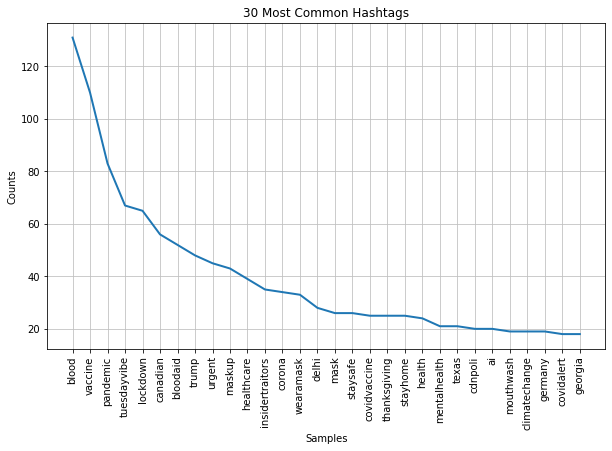

In [ ]:
fig = plt.figure(figsize = (10,6))
fdist.plot(30, cumulative=False, title = '30 Most Common Hashtags')
plt.show()

## Exploratory Analysis

### Tweets Character Length

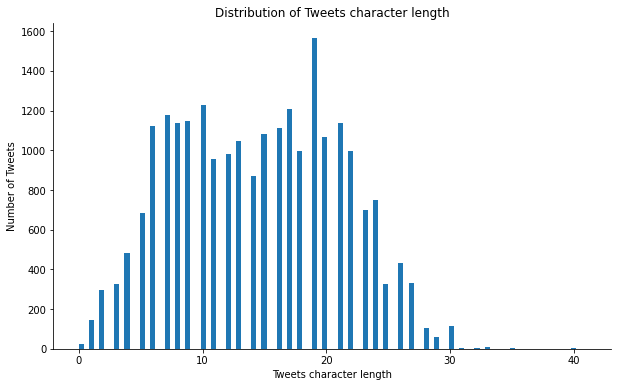

In [ ]:
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in tweets_df_clean.text]
plt.hist(doc_lens, bins = 100)
plt.title('Distribution of Tweets character length')
plt.ylabel('Number of Tweets')
plt.xlabel('Tweets character length')
sns.despine();

### Wordcloud

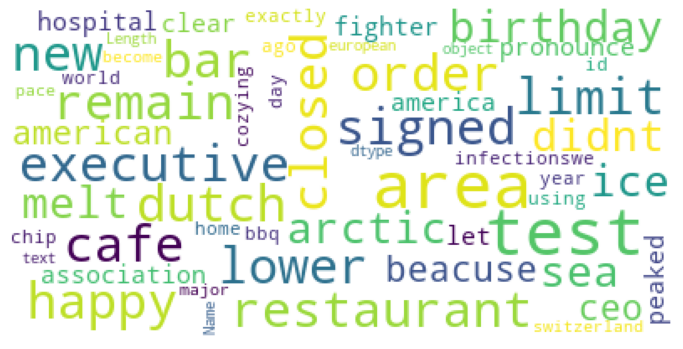

In [ ]:
mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                      background_color='white',
                      stopwords=stopwords,
                      max_words=500,
                      max_font_size=40, 
                      random_state=100
                      ).generate(str(tweets_df_clean.text))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [ ]:
# Flatten tweets
flat_list = [item for sublist in tweets_df_clean.text for item in sublist]

from sklearn.feature_extraction.text import CountVectorizer

# CountVectorize
vectorizer = CountVectorizer(
                            analyzer='word',       
                            min_df=3, # minimum required occurences of a word 
                            token_pattern='[a-zA-Z0-9]{3,}', # num chars > 3
                            max_features=5000, # max number of unique words
                            )
data_matrix = vectorizer.fit_transform(flat_list)

# The 10 most common words
sum_words = data_matrix.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq[:20]

[('people', 2688),
 ('case', 2496),
 ('new', 2278),
 ('vaccine', 2215),
 ('world', 1750),
 ('pandemic', 1738),
 ('mask', 1715),
 ('death', 1706),
 ('one', 1550),
 ('need', 1301),
 ('health', 1288),
 ('help', 1287),
 ('get', 1193),
 ('population', 1187),
 ('today', 1160),
 ('test', 1151),
 ('year', 1109),
 ('say', 1068),
 ('state', 1057),
 ('family', 1026)]

-------
# Build The LDA Model
#### Baseline model using K = 10

In [ ]:
# Create a dictionary of tokens
id2word = Dictionary(list(tweets_df_clean["text"]))

# Create a corpus object. Term document frequency
corpus = [id2word.doc2bow(token) for token in tweets_df_clean["text"]]

# Base LDA model 
lda_model = LdaMulticore(
                          num_topics = 10, # Number of topics        
                          corpus = corpus,
                          id2word = id2word, 
                          random_state=20,      
                          passes = 10,
                          per_word_topics=True
                          )

In [ ]:
# Print the Keyword in the 10 topics
print("Topics found via LDA:")
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

Topics found via LDA:
[(0,
  '0.013*"people" + 0.012*"school" + 0.011*"testing" + 0.008*"health" + '
  '0.008*"spread" + 0.007*"say" + 0.007*"vaccine" + 0.006*"student" + '
  '0.006*"worker" + 0.006*"infected"'),
 (1,
  '0.014*"people" + 0.013*"trading" + 0.013*"insider" + 0.013*"would" + '
  '0.013*"u" + 0.010*"two" + 0.010*"senator" + 0.009*"soon" + 0.009*"stock" + '
  '0.009*"loeffler"'),
 (2,
  '0.018*"case" + 0.010*"first" + 0.010*"people" + 0.009*"positive" + '
  '0.009*"new" + 0.009*"need" + 0.008*"health" + 0.008*"hospital" + '
  '0.007*"patient" + 0.007*"pandemic"'),
 (3,
  '0.018*"mask" + 0.016*"state" + 0.011*"u" + 0.009*"country" + '
  '0.009*"governor" + 0.009*"need" + 0.008*"mandate" + 0.008*"new" + '
  '0.008*"restriction" + 0.007*"may"'),
 (4,
  '0.019*"pandemic" + 0.015*"second" + 0.015*"study" + 0.013*"found" + '
  '0.011*"kill" + 0.011*"trump" + 0.011*"food" + 0.010*"within" + '
  '0.010*"people" + 0.010*"new"'),
 (5,
  '0.031*"case" + 0.025*"death" + 0.018*"new" + 0

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.095134  0.056170       1        1  13.369788
2      0.076264 -0.025489       2        1  13.065826
5     -0.012627 -0.199263       3        1  11.944862
9      0.099224  0.037146       4        1  10.394224
3      0.024094  0.015828       5        1  10.030468
6      0.054015 -0.055384       6        1   9.906461
7      0.070941  0.269066       7        1   8.423963
8     -0.386723  0.074357       8        1   8.221094
4     -0.005916  0.022679       9        1   7.578131
1     -0.014406 -0.195110      10        1   7.065182, topic_info=            Term         Freq        Total Category  logprob  loglift
61       vaccine  2127.000000  2127.000000  Default  30.0000  30.0000
188        world  1595.000000  1595.000000  Default  29.0000  29.0000
139         case  2320.000000  2320.000000  Default  28.0000  28.0000
451   population   979.000000   979.000000  Default  27.0000  27.0000
1318        folk   897.000000   897.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
347            u   303.982368  1535.081789  Topic10  -4.3776   1.0306
10        people   338.318735  2516.480419  Topic10  -4.2705   0.6434
1406        jail   162.753785   377.063387  Topic10  -5.0023   1.8098
37          year   207.325200   987.531697  Topic10  -4.7602   1.0891
1409      senate   204.214679   983.412451  Topic10  -4.7754   1.0781

[649 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1069      1  0.189473    able
1069      9  0.807943    able
1758      2  0.096942  active
1758      3  0.900986  active
124       2  0.982571      ad
...     ...       ...     ...
794       3  0.257844       —
794       5  0.020223       —
794       6  0.005056       —
794       8  0.475243       —
3690      9  0.991718       •

[1317 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 6, 10, 4, 7, 8, 9, 5, 2])

## Selecting the best number of topics (K)

### k=4

In [ ]:
# Create a dictionary of tokens
id2word = Dictionary(list(tweets_df_clean["text"]))

# Create a corpus object. Term document frequency
corpus = [id2word.doc2bow(token) for token in tweets_df_clean["text"]]

# Base LDA model 
lda_model_2 = LdaMulticore(
                          num_topics = 4, # Number of topics        
                          corpus = corpus,
                          id2word = id2word, 
                          random_state=20,      
                          passes = 10,
                          per_word_topics=True
                          )


In [ ]:
# Print the Keyword in the 4 topics
print("Topics found via LDA:")
pprint(lda_model_2.print_topics())
doc_lda = lda_model_2[corpus]

Topics found via LDA:
[(0,
  '0.010*"people" + 0.006*"pandemic" + 0.006*"school" + 0.006*"health" + '
  '0.005*"testing" + 0.005*"time" + 0.005*"trump" + 0.005*"government" + '
  '0.005*"test" + 0.004*"due"'),
 (1,
  '0.031*"vaccine" + 0.010*"birthday" + 0.010*"one" + 0.010*"year" + '
  '0.008*"effective" + 0.008*"dolly" + 0.008*"u" + 0.007*"parton" + '
  '0.007*"modernas" + 0.007*"people"'),
 (2,
  '0.019*"case" + 0.011*"new" + 0.009*"mask" + 0.008*"death" + 0.008*"people" '
  '+ 0.007*"need" + 0.006*"positive" + 0.006*"today" + 0.006*"wear" + '
  '0.006*"virus"'),
 (3,
  '0.025*"world" + 0.017*"folk" + 0.015*"population" + 0.011*"crisis" + '
  '0.008*"half" + 0.008*"aviation" + 0.008*"emission" + 0.008*"climate" + '
  '0.007*"causing" + 0.007*"caused"')]


### k=5

In [ ]:
# Create a dictionary of tokens
id2word = Dictionary(list(tweets_df_clean["text"]))

# Create a corpus object. Term document frequency
corpus = [id2word.doc2bow(token) for token in tweets_df_clean["text"]]

# Base LDA model 
lda_model_2 = LdaMulticore(
                          num_topics = 5, # Number of topics          
                          corpus = corpus,
                          id2word = id2word, 
                          random_state=20,      
                          passes = 10,
                          per_word_topics=True
                          )


In [ ]:
# Print the Keyword in the 5 topics
print("Topics found via LDA:")
pprint(lda_model_2.print_topics())
doc_lda = lda_model_2[corpus]

Topics found via LDA:
[(0,
  '0.011*"people" + 0.007*"health" + 0.006*"school" + 0.006*"get" + '
  '0.006*"testing" + 0.006*"test" + 0.005*"due" + 0.004*"say" + 0.004*"work" + '
  '0.004*"student"'),
 (1,
  '0.022*"vaccine" + 0.014*"one" + 0.011*"birthday" + 0.010*"year" + '
  '0.009*"effective" + 0.008*"family" + 0.008*"get" + 0.008*"modernas" + '
  '0.008*"data" + 0.008*"u"'),
 (2,
  '0.022*"case" + 0.014*"new" + 0.009*"death" + 0.008*"today" + '
  '0.008*"positive" + 0.007*"mask" + 0.007*"virus" + 0.007*"help" + '
  '0.006*"day" + 0.006*"people"'),
 (3,
  '0.033*"world" + 0.020*"population" + 0.015*"crisis" + 0.011*"half" + '
  '0.010*"aviation" + 0.010*"emission" + 0.010*"climate" + 0.010*"causing" + '
  '0.010*"caused" + 0.009*"responsible"'),
 (4,
  '0.017*"folk" + 0.013*"vaccine" + 0.010*"pandemic" + 0.009*"death" + '
  '0.008*"going" + 0.008*"new" + 0.007*"study" + 0.007*"trump" + '
  '0.006*"mouthwash" + 0.006*"american"')]


### k=6

In [ ]:
# Create a dictionary of tokens
id2word = Dictionary(list(tweets_df_clean["text"]))

# Create a corpus object. Term document frequency
corpus = [id2word.doc2bow(token) for token in tweets_df_clean["text"]]

# Base LDA model 
lda_model_2 = LdaMulticore(
                          num_topics = 6, # Number of topics         
                          corpus = corpus,
                          id2word = id2word, 
                          random_state=20,      
                          passes = 10,
                          per_word_topics=True
                          )

In [ ]:
# Print the Keyword in the 6 topics
print("Topics found via LDA:")
pprint(lda_model_2.print_topics())
doc_lda = lda_model_2[corpus]

Topics found via LDA:
[(0,
  '0.009*"school" + 0.008*"health" + 0.008*"people" + 0.008*"testing" + '
  '0.006*"spread" + 0.005*"student" + 0.005*"due" + 0.005*"test" + 0.005*"get" '
  '+ 0.005*"tested"'),
 (1,
  '0.028*"vaccine" + 0.015*"birthday" + 0.014*"one" + 0.013*"year" + '
  '0.012*"dolly" + 0.011*"parton" + 0.011*"effective" + 0.011*"family" + '
  '0.010*"modernas" + 0.009*"people"'),
 (2,
  '0.009*"people" + 0.008*"pandemic" + 0.007*"need" + 0.006*"health" + '
  '0.005*"new" + 0.005*"get" + 0.005*"mask" + 0.004*"positive" + 0.004*"care" '
  '+ 0.004*"help"'),
 (3,
  '0.039*"world" + 0.027*"folk" + 0.024*"population" + 0.017*"crisis" + '
  '0.013*"half" + 0.012*"aviation" + 0.012*"emission" + 0.012*"climate" + '
  '0.012*"causing" + 0.011*"caused"'),
 (4,
  '0.017*"vaccine" + 0.012*"study" + 0.012*"pandemic" + 0.009*"make" + '
  '0.009*"new" + 0.008*"trump" + 0.008*"fund" + 0.008*"american" + '
  '0.008*"people" + 0.007*"million"'),
 (5,
  '0.036*"case" + 0.018*"death" + 0.014*

### k=8

In [ ]:
# Create a dictionary of tokens
id2word = Dictionary(list(tweets_df_clean["text"]))

# Create a corpus object. Term document frequency
corpus = [id2word.doc2bow(token) for token in tweets_df_clean["text"]]

# Base LDA model 
lda_model_2 = LdaMulticore(
                          num_topics = 8, # Number of topics          
                          corpus = corpus,
                          id2word = id2word, 
                          random_state=20,      
                          passes = 10,
                          per_word_topics=True
                          )

In [ ]:
# Print the Keyword in the 8 topics
print("Topics found via LDA:")
pprint(lda_model_2.print_topics())
doc_lda = lda_model_2[corpus]

Topics found via LDA:
[(0,
  '0.013*"people" + 0.009*"testing" + 0.009*"health" + 0.007*"school" + '
  '0.007*"student" + 0.006*"due" + 0.006*"test" + 0.006*"work" + 0.005*"need" '
  '+ 0.005*"worker"'),
 (1,
  '0.019*"birthday" + 0.014*"year" + 0.012*"lost" + 0.011*"u" + 0.011*"happy" '
  '+ 0.010*"community" + 0.010*"help" + 0.010*"family" + 0.010*"trading" + '
  '0.010*"insider"'),
 (2,
  '0.013*"people" + 0.010*"need" + 0.009*"get" + 0.008*"positive" + '
  '0.006*"country" + 0.006*"keep" + 0.006*"mask" + 0.006*"dont" + 0.006*"care" '
  '+ 0.005*"pandemic"'),
 (3,
  '0.042*"world" + 0.031*"population" + 0.022*"crisis" + 0.017*"half" + '
  '0.016*"aviation" + 0.016*"emission" + 0.016*"climate" + 0.015*"causing" + '
  '0.015*"caused" + 0.015*"super"'),
 (4,
  '0.016*"pandemic" + 0.015*"study" + 0.012*"second" + 0.009*"found" + '
  '0.009*"people" + 0.009*"kill" + 0.009*"trump" + 0.009*"within" + '
  '0.009*"food" + 0.008*"new"'),
 (5,
  '0.041*"case" + 0.022*"death" + 0.014*"new" + 0.

### k=9

In [ ]:
# Create a dictionary of tokens
id2word = Dictionary(list(tweets_df_clean["text"]))

# Create a corpus object. Term document frequency
corpus = [id2word.doc2bow(token) for token in tweets_df_clean["text"]]

# Base LDA model 
lda_model_2 = LdaMulticore(
                          num_topics = 9, # Number of topics          
                          corpus = corpus,
                          id2word = id2word, 
                          random_state=20,      
                          passes = 10,
                          per_word_topics=True
                          )

In [ ]:
# Print the Keyword in the 9 topics
print("Topics found via LDA:")
pprint(lda_model_2.print_topics())
doc_lda = lda_model_2[corpus]

Topics found via LDA:
[(0,
  '0.011*"testing" + 0.010*"people" + 0.010*"health" + 0.010*"school" + '
  '0.007*"student" + 0.007*"test" + 0.006*"spread" + 0.006*"work" + '
  '0.006*"due" + 0.006*"getting"'),
 (1,
  '0.018*"year" + 0.014*"birthday" + 0.013*"people" + 0.012*"happy" + '
  '0.008*"vaccine" + 0.007*"hope" + 0.007*"last" + 0.007*"stock" + '
  '0.007*"corona" + 0.007*"loeffler"'),
 (2,
  '0.015*"mask" + 0.012*"people" + 0.012*"wear" + 0.011*"even" + 0.010*"virus" '
  '+ 0.010*"senate" + 0.010*"help" + 0.010*"still" + 0.009*"pandemic" + '
  '0.008*"get"'),
 (3,
  '0.017*"mask" + 0.014*"state" + 0.011*"u" + 0.009*"country" + 0.008*"need" + '
  '0.008*"restriction" + 0.007*"mandate" + 0.007*"also" + 0.007*"governor" + '
  '0.006*"spread"'),
 (4,
  '0.016*"pandemic" + 0.015*"study" + 0.012*"second" + 0.012*"trump" + '
  '0.010*"people" + 0.010*"new" + 0.009*"found" + 0.008*"kill" + '
  '0.008*"within" + 0.008*"food"'),
 (5,
  '0.044*"case" + 0.024*"death" + 0.015*"new" + 0.012*"nu

## Best number of topics (K=7)
## Final model

### k=7

In [ ]:
# Create a dictionary of tokens
id2word = Dictionary(list(tweets_df_clean["text"]))

# Create a corpus object. Term document frequency
corpus = [id2word.doc2bow(token) for token in tweets_df_clean["text"]]

# Base LDA model 
lda_model_2 = LdaMulticore(
                          num_topics = 7, # Number of topics          
                          corpus = corpus,
                          id2word = id2word, 
                          random_state=20,      
                          passes = 10,
                          per_word_topics=True
                          )

In [ ]:
# Print the Keyword in the 7 topics
print("Topics found via LDA:")
pprint(lda_model_2.print_topics())
doc_lda = lda_model_2[corpus]

Topics found via LDA:
[(0,
  '0.013*"health" + 0.010*"people" + 0.010*"school" + 0.009*"testing" + '
  '0.007*"student" + 0.006*"due" + 0.006*"need" + 0.006*"test" + '
  '0.006*"public" + 0.006*"spread"'),
 (1,
  '0.027*"vaccine" + 0.016*"birthday" + 0.015*"data" + 0.014*"one" + 0.012*"u" '
  '+ 0.011*"year" + 0.010*"effective" + 0.010*"happy" + 0.010*"early" + '
  '0.010*"dolly"'),
 (2,
  '0.010*"people" + 0.010*"pandemic" + 0.007*"need" + 0.006*"positive" + '
  '0.006*"get" + 0.005*"many" + 0.005*"u" + 0.004*"dont" + 0.004*"virus" + '
  '0.004*"way"'),
 (3,
  '0.047*"world" + 0.028*"population" + 0.021*"crisis" + 0.015*"half" + '
  '0.015*"aviation" + 0.015*"emission" + 0.014*"climate" + 0.014*"causing" + '
  '0.014*"caused" + 0.013*"super"'),
 (4,
  '0.029*"vaccine" + 0.013*"new" + 0.013*"study" + 0.012*"pandemic" + '
  '0.011*"second" + 0.010*"research" + 0.010*"million" + 0.009*"fund" + '
  '0.009*"american" + 0.008*"market"'),
 (5,
  '0.037*"case" + 0.021*"death" + 0.014*"new" + 

In [ ]:
# Compute Perplexity 
base_perplexity = lda_model_2.log_perplexity(corpus)
print("\nPerplexity: ", base_perplexity)

# Compute Coherence Score
coherence_model = CoherenceModel(model = lda_model_2, texts = tweets_df_clean["text"],
                                 coherence = "c_v")
coherence_lda_model_base = coherence_model.get_coherence()
print("\nCoherence Score: ", coherence_lda_model_base)


Perplexity:  -7.847472968719972

Coherence Score:  0.35083422663004704


----


## Rename 7 Topics

In [ ]:
topics={0:'Back-to-School',1:'COVID B-Day',2:'New Cases',3:'Climate Change',4:'Vaccine Research',5:'Covid Protection',6:'Thanksgiving Gathering'}

In [ ]:
def get_topic(tweet):

    tokens = data_processing(tweet)
    result=lda_model_2[id2word.doc2bow(tokens)][0]
    
    d={}
    
    for i in result:
        d[i[0]]=i[1]
    
    key=max(d, key=d.get)
    
    return topics[key]
    


In [ ]:
test2 = df

test2['topic']= ''

test2.loc[:, 'topic']=test2['text'].apply(lambda x: get_topic(x))

test2.to_csv('result.csv')

In [ ]:
test2.tail()

,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,topic
49995,SamanthasLaw,"Family-Centred Care Advocate, Founder of SAMAN...",Canada,4562,2391,116969,2012-04-24 03:58:37,2020-11-17 16:50:01,26,Premier Doug Ford went on the defensive today ...,[],New Cases
49996,NashvilleResist,We/us (more than one person writes this accoun...,"Nashville, TN",12324,12219,68014,2016-09-25 20:17:01,2020-11-17 16:50:01,8,They've canceled the Rock'n'Roll Marathon in N...,[],Covid Protection
49997,stemnorth,STEAM learning resources for @ASDNnb,"New Brunswick, Canada",135,336,485,2015-11-17 23:59:35,2020-11-17 16:50:01,1,"Due to COVID-19, The Giving Tree is going virt...",[],New Cases
49998,larthal,"Lungo un cammino di miglioramento, con le gino...",Terzo dal sole,323,223,10500,2009-04-17 10:43:51,2020-11-17 16:50:00,354,"‘Their last dying words are, ‘This can’t happe...",[],Covid Protection
49999,SteveinSL,"Former resident of Batticaloa, Sri Lanka.\n\nF...","Criccieth, Wales",128,154,2630,2015-07-27 11:47:27,2020-11-17 16:50:00,195,Please use this COVID trivia to annoy everyone...,[],Climate Change


#### Testing with random tweets 


In [ ]:
new_text = 'we can slow the spread save lives and get back to our lives with our loved ones'
tokens = [token for token in word_tokenize(new_text.lower())]
result=lda_model_2[id2word.doc2bow(tokens)]
result[0]

[(0, 0.017922398),
 (1, 0.017858943),
 (2, 0.41674498),
 (3, 0.01788935),
 (4, 0.018028755),
 (5, 0.01790851),
 (6, 0.49364704)]

----

# Apply Sentiment To Tweets For Analysis



### Apply Clean function to test2  

In [ ]:
punct=string.punctuation+'”‘’“'
stopwords = nltk.corpus.stopwords.words("english")
custom_stopwords = ['hi', '&amp;', 'amp', 'amp;', 'got', "it's", 'it’s', "i'm", 'im', 'want', 'like', '$', '@','-', 'covid','coronavirus','covid19','covid-19','u', "U"]
for i in custom_stopwords:
    stopwords.append(i)

In [ ]:
def clean(text):

    # Remove URL
    url = re.compile(r'http\S+')
    text=url.sub(r'',text)

    # Remove html tags
    html=re.compile(r'<.*?>')
    text=html.sub(r'',text)
    
    # Remove emojis
    text = demoji.replace(text, "")
    
    # Remove mentions and hashtag
    text=re.sub(r'@\w+','',text)        # remove mentions
    text=re.sub(r'#\w+','',text)        # remove hashtag
    
    # Remove Emails
    email = re.compile(r'\S*@\S*\s?')
    text=email.sub(r'', text)
    
    # Remove new line characters
    newline = re.compile(r'\n+')
    text=newline.sub(r'', text)
    
    # Remove extra white space left while removing stuff
    whitespace_remove = re.compile(r'\s+')
    text=whitespace_remove.sub(r' ', text)
    
    # Make text lowercase
    text = text.lower()

    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)

    # Remove punctuation   
    text = re.sub(r'[%s]' % re.escape(punct), '', text)    

    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Remove stopwords
    text=" ".join(word for word in str(text).split() if word not in stopwords)

    return text 

In [ ]:
test2['text_cleaned']=test2['text'].apply(lambda x:clean(x))

In [ ]:
test2.head()

,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,topic,text_cleaned
0,KavitaNair,🇺🇸 🌟 Personal Account 🌟 Instagram @thekavitana...,NaN,291,733,7374,2008-09-18 01:08:47,2020-11-17 18:07:31,137,NEW: I just signed an Executive Order to lower...,"[{'text': 'COVID19', 'indices': [131, 139]}]",Thanksgiving Gathering,new signed executive order lower limits indoor...
1,annaholligan,Foreign correspondent @bbcnews Journalist. Fil...,"The Hague, The Netherlands",8168,23749,18951,2009-01-17 06:58:29,2020-11-17 18:07:31,0,"Dutch bars, cafes and restaurants will remain ...","[{'text': 'COVID19', 'indices': [259, 267]}]",Thanksgiving Gathering,dutch bars cafes restaurants remain closed exc...
2,Champlow,Ubisoft⭐️_PLAYER 2019 x Trials Elite x Admin a...,Mordor,284,376,5078,2013-12-05 14:03:36,2020-11-17 18:07:31,0,Happy birthday 🙃\n#Covid_19 https://t.co/vIzzA...,"[{'text': 'Covid_19', 'indices': [17, 26]}]",COVID B-Day,happy birthday
3,stshank,"Senior editor, CNET News. I cover browsers, ph...","SF Bay Area, CA",3633,30489,57043,2007-06-05 14:47:23,2020-11-17 18:07:31,0,The area of arctic sea ice that didn't melt be...,[],COVID B-Day,area arctic sea ice didnt melt beacuse blinkon...
4,JoelJeffcoat,NaN,NaN,293,113,19637,2017-04-18 18:30:24,2020-11-17 18:07:31,30,This is where we are. CEOs of the American Hos...,[],Back-to-School,ceos american hospital association american me...


### Extract test set

In [ ]:
X_test2 = test2['text_cleaned'].copy()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(test2['text_cleaned'])
vocab_size = len(tokenizer.word_index)+1

X_test2 = tokenizer.texts_to_sequences(X_test2)
X_test2 = pad_sequences(X_test2, padding='post')

### Load LSTM model for sentiment analysis

In [ ]:
sentiment_model = tf.keras.models.load_model('/content/drive/MyDrive/Master - Classes/CIS 9665 - NLP/NLP Group Project/saved_model/my_model')

# Check its architecture
sentiment_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 51, 16)            588208    
_________________________________________________________________
bidirectional (Bidirectional (None, 51, 512)           559104    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [ ]:
pred2 = sentiment_model.predict_classes(X_test2)
test2.loc[:,'sentiment']=pred2

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
test2.head()

,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,topic,text_cleaned,sentiment
0,KavitaNair,🇺🇸 🌟 Personal Account 🌟 Instagram @thekavitana...,NaN,291,733,7374,2008-09-18 01:08:47,2020-11-17 18:07:31,137,NEW: I just signed an Executive Order to lower...,"[{'text': 'COVID19', 'indices': [131, 139]}]",Thanksgiving Gathering,new signed executive order lower limits indoor...,0
1,annaholligan,Foreign correspondent @bbcnews Journalist. Fil...,"The Hague, The Netherlands",8168,23749,18951,2009-01-17 06:58:29,2020-11-17 18:07:31,0,"Dutch bars, cafes and restaurants will remain ...","[{'text': 'COVID19', 'indices': [259, 267]}]",Thanksgiving Gathering,dutch bars cafes restaurants remain closed exc...,2
2,Champlow,Ubisoft⭐️_PLAYER 2019 x Trials Elite x Admin a...,Mordor,284,376,5078,2013-12-05 14:03:36,2020-11-17 18:07:31,0,Happy birthday 🙃\n#Covid_19 https://t.co/vIzzA...,"[{'text': 'Covid_19', 'indices': [17, 26]}]",COVID B-Day,happy birthday,1
3,stshank,"Senior editor, CNET News. I cover browsers, ph...","SF Bay Area, CA",3633,30489,57043,2007-06-05 14:47:23,2020-11-17 18:07:31,0,The area of arctic sea ice that didn't melt be...,[],COVID B-Day,area arctic sea ice didnt melt beacuse blinkon...,2
4,JoelJeffcoat,NaN,NaN,293,113,19637,2017-04-18 18:30:24,2020-11-17 18:07:31,30,This is where we are. CEOs of the American Hos...,[],Back-to-School,ceos american hospital association american me...,2


### Swap with sentiment categories in actual words & export

In [ ]:
encoding2 = {0: 'Negative',1:'Neutral',2:'Positive'}

labels = ['Negative', 'Neutral', 'Positive']
           
test2['sentiment']=test2['sentiment'].map(encoding2)

Sentiment & Topic Analysis

In [ ]:
test2.head()

,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,topic,clean,text_cleaned,sentiment
0,ðŸ‡ºðŸ‡¸ ðŸŒŸ Personal Account ðŸŒŸ Instagram ...,NaN,291.0,733.0,7374.0,2008-09-18 01:08:00,2020-11-17 18:07:00,137.0,NEW: I just signed an Executive Order to lower...,"[{'text': 'COVID19', 'indices': [131, 139]}]",Holiday Gathering,"['new', 'signed', 'executive', 'order', 'lower...",new signed executive order lower limit indoor ...,Positive
1,Foreign correspondent @bbcnews Journalist. Fil...,"The Hague, The Netherlands",8168.0,23749.0,18951.0,2009-01-17 06:58:00,2020-11-17 18:07:00,0.0,"Dutch bars, cafes and restaurants will remain ...","[{'text': 'COVID19', 'indices': [259, 267]}]",Covid Protection,"['dutch', 'bar', 'cafe', 'restaurant', 'will',...",dutch bar cafe restaurant remain closed except...,Positive
2,Ubisoftâ­ï¸_PLAYER 2019 x Trials Elite x Adm...,Mordor,284.0,376.0,5078.0,2013-12-05 14:03:00,2020-11-17 18:07:00,0.0,Happy birthday ðŸ™ƒ\n#Covid_19 https://t.co/vI...,"[{'text': 'Covid_19', 'indices': [17, 26]}]",COVID B-Day,"['happy', 'birthday']",happy birthday,Positive
3,"Senior editor, CNET News. I cover browsers, ph...","SF Bay Area, CA",3633.0,30489.0,57043.0,2007-06-05 14:47:00,2020-11-17 18:07:00,0.0,The area of arctic sea ice that didn't melt be...,[],COVID B-Day,"['area', 'arctic', 'sea', 'ice', 'didnt', 'mel...",area arctic sea ice didnt melt beacuse blinkon...,Positive
4,NaN,NaN,293.0,113.0,19637.0,2017-04-18 18:30:00,2020-11-17 18:07:00,30.0,This is where we are. CEOs of the American Hos...,[],Back-to-School,"['ceo', 'american', 'hospital', 'association',...",ceo american hospital association american med...,Positive


Count by Topic

In [ ]:
test2.groupby(['topic'])['acctdesc'].count()

topic
Back-to-School       8851
COVID B-Day          4770
Climate Change       2570
Covid Protection     8124
Government Action    4753
Holiday Gathering    6073
New Cases            8353
Name: acctdesc, dtype: int64

Sum Retweets by Topic

In [ ]:
test2.groupby(['topic'])['retweetcount'].sum()

topic
Back-to-School       1794390.0
COVID B-Day          3134895.0
Climate Change       2648611.0
Covid Protection     5647011.0
Government Action    3795325.0
Holiday Gathering    2034871.0
New Cases            2483048.0
Name: retweetcount, dtype: float64

Topic Sentiment Analysis

In [ ]:
test2.groupby(['topic','sentiment'])['acctdesc'].count()/test2.groupby(['topic'])['acctdesc'].count()

topic              sentiment
Back-to-School     Negative     0.285843
                   Neutral      0.175460
                   Positive     0.538696
COVID B-Day        Negative     0.255346
                   Neutral      0.120335
                   Positive     0.624319
Climate Change     Negative     0.461089
                   Neutral      0.156809
                   Positive     0.382101
Covid Protection   Negative     0.406204
                   Neutral      0.190423
                   Positive     0.403373
Government Action  Negative     0.539028
                   Neutral      0.151483
                   Positive     0.309489
Holiday Gathering  Negative     0.305780
                   Neutral      0.126791
                   Positive     0.567430
New Cases          Negative     0.363702
                   Neutral      0.109541
                   Positive     0.526757
Name: acctdesc, dtype: float64